## Javier Mombiela
## Carnet: 20067
## 15 de abril, 2024

### Laboratorio #6 – Análisis de tráfico, implementación de un IDS

#### Preámbulo

In [68]:
import binascii
import pandas as pd
from scapy.all import *
import matplotlib.pyplot as plt
from scapy.layers.inet import IP
from scapy.layers.l2 import Ether
from scapy.layers.inet import TCP, UDP

2. Capturar 25 paquetes

In [24]:
num_of_packets_to_sniff = 25
pcap = sniff(count=num_of_packets_to_sniff)

3. Imprimir el tipo de variable, longitud y contenido

In [25]:
# Imprimir tipo de variable
print("Tipo de variable: ", type(pcap))

# Imprimir longitud de la variable
print("Longitud de la variable: ", len(pcap))

# Imprimir el contenido de la variable
print("Contenido de la variable: ")
print(pcap)

Tipo de variable:  <class 'scapy.plist.PacketList'>
Longitud de la variable:  25
Contenido de la variable: 
<Sniffed: TCP:23 UDP:2 ICMP:0 Other:0>


4. Imprimir tipo de dato del primer paquete

In [26]:
print(pcap[0])
print("Tipo de dato del primer paquete capturado: ", type(pcap[0]))

Ether / IP / TCP 192.168.1.17:61455 > 20.50.201.200:https PA / Raw
Tipo de dato del primer paquete capturado:  <class 'scapy.layers.l2.Ether'>


5. Imrpimir el contenido de 5 paquetes

In [32]:
print("Contenido de los primeros 5 paquetes capturados: \n")

for i in range(5):
    print("Paquete número: ", i+1)
    print(pcap[i])
    print("-" * 55)

Contenido de los primeros 5 paquetes capturados: 

Paquete número:  1
Ether / IP / UDP / DNS Qry "b'google.com.'"  / Raw
-------------------------------------------------------
Paquete número:  2
Ether / IP / UDP / DNS Ans "2607:f8b0:4005:807::200e" 
-------------------------------------------------------
Paquete número:  3
Ether / IP / UDP / DNS Qry "b'google.com.'"  / Raw
-------------------------------------------------------
Paquete número:  4
Ether / IP / UDP / DNS Ans "2607:f8b0:4005:807::200e" 
-------------------------------------------------------
Paquete número:  5
Ether / IP / UDP / DNS Qry "b'google.com.'"  / Raw
-------------------------------------------------------


#### Análisis estadístico

1. Cargar `analisis_paquetes.pcap` a una variable

In [33]:
pcap_file = 'analisis_paquetes.pcap'
pcap = rdpcap(pcap_file)

2. Convertir la variable a un DataFrame

In [36]:
# Obtener los campos de la capa 2
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

# Concatenar campos
fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Crear un DataFrame vacío
df = pd.DataFrame(columns=fields)

# Rellenar el DataFrame con los paquetes capturados
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])

    field_values.append(packet.time)

    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)

    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

3. Mostrar el contenido de las primeras 5 filas

In [46]:
df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,32,84,58919,,0,122,17,13836,...,None,None,None,None,65061,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,32,84,59493,,0,122,17,13262,...,None,None,None,None,65063,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


4. Mostras los valores de: Src Address, Dst Address, Src Port y Dst Port

In [49]:
df[['src', 'dst', 'sport', 'dport']]

,src,dst,sport,dport
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53
...,...,...,...,...
57,84.54.22.33,10.1.10.53,53,53
58,10.1.10.53,84.54.22.33,53,53
59,84.54.22.33,10.1.10.53,53,53
60,10.1.10.53,84.54.22.33,53,53


**5. Estadisticas**

 a. Mostrar todas las IP origen

In [51]:
print(df['src'].unique())

['10.1.10.53' '84.54.22.33' '75.75.75.75']


b. Mostrar todas las IP destino

In [52]:
print(df['dst'].unique())

['84.54.22.33' '10.1.10.53' '75.75.75.75']


c. ¿Cuál es la IP origen más frecuente?
- ¿A qué IP destino se comunica con más frecuencia?
- ¿A que puerto destino se comunica? ¿Cuál es el propósito de este puerto?
- ¿Desde que puertos origen se comunica?

In [81]:
# Encontrar la IP origen mas frecuente
most_frequent_src_ip = df['src'].value_counts().idxmax()

print("IP origen más frecuente: ", most_frequent_src_ip)

# Filtrar el dataframe por la IP de origen mas frecuente
filtered_df = df[df['src'] == most_frequent_src_ip]

# A qué IP destino se comunica con más frecuencia
most_frequent_dst_ip = filtered_df['dst'].value_counts().idxmax()

# A qué puerto destino se comunica y su propósito
most_frequent_dport = filtered_df['dport'].value_counts().idxmax()
purpose_of_dport = "El puerto 53 se utiliza para la resolución de nombres de dominio, lo que permite que los dispositivos se comuniquen entre sí en Internet utilizando nombres legibles para los humanos en lugar de direcciones IP numéricas."

# Desde qué puertos de origen se comunica
source_ports = filtered_df['sport'].unique()

print("\nA qué IP destino se comunica con más frecuencia:", most_frequent_dst_ip)
print("A qué puerto destino se comunica:", most_frequent_dport)
print("Propósito del puerto destino:", purpose_of_dport)
print("Se comunica desde los siguientes puertos:", source_ports)

IP origen más frecuente:  10.1.10.53

A qué IP destino se comunica con más frecuencia: 84.54.22.33
A qué puerto destino se comunica: 53
Propósito del puerto destino: El puerto 53 se utiliza para la resolución de nombres de dominio, lo que permite que los dispositivos se comuniquen entre sí en Internet utilizando nombres legibles para los humanos en lugar de direcciones IP numéricas.
Se comunica desde los siguientes puertos: [53 15812 23903]


**6. Gráficas**

a. Grafica suma de payloads de IP Orgigen

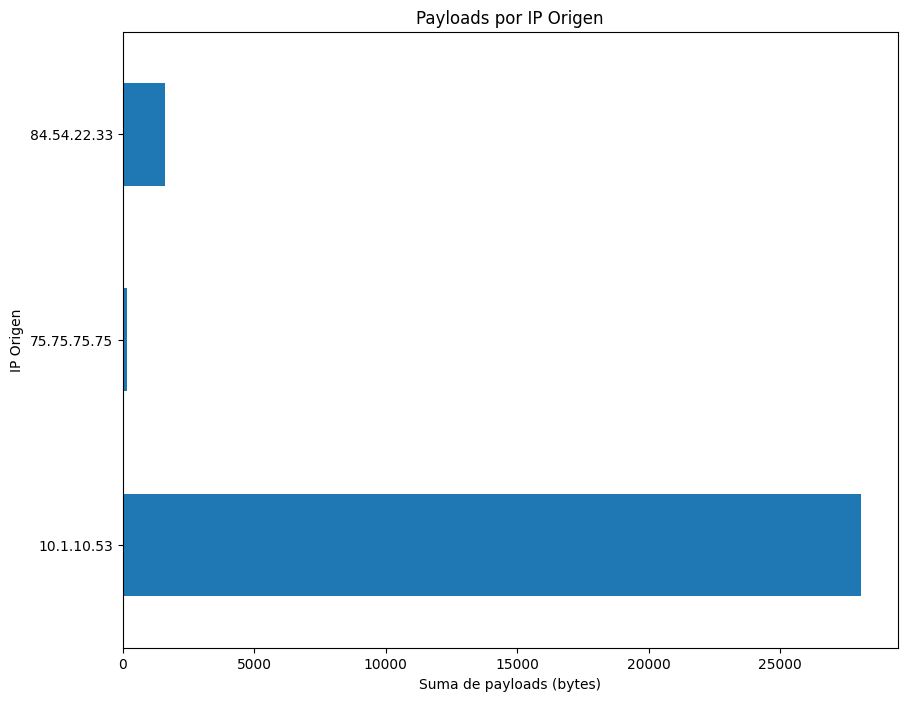

In [79]:
payloads_por_ip_origen = df.groupby('src')['payload'].sum()

# Crear la graficas
plt.figure(figsize=(10, 8))
payloads_por_ip_origen.plot(kind='barh')
plt.title('Payloads por IP Origen')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('IP Origen')
plt.show()

b. Grafica suma de payloads Ip Destino

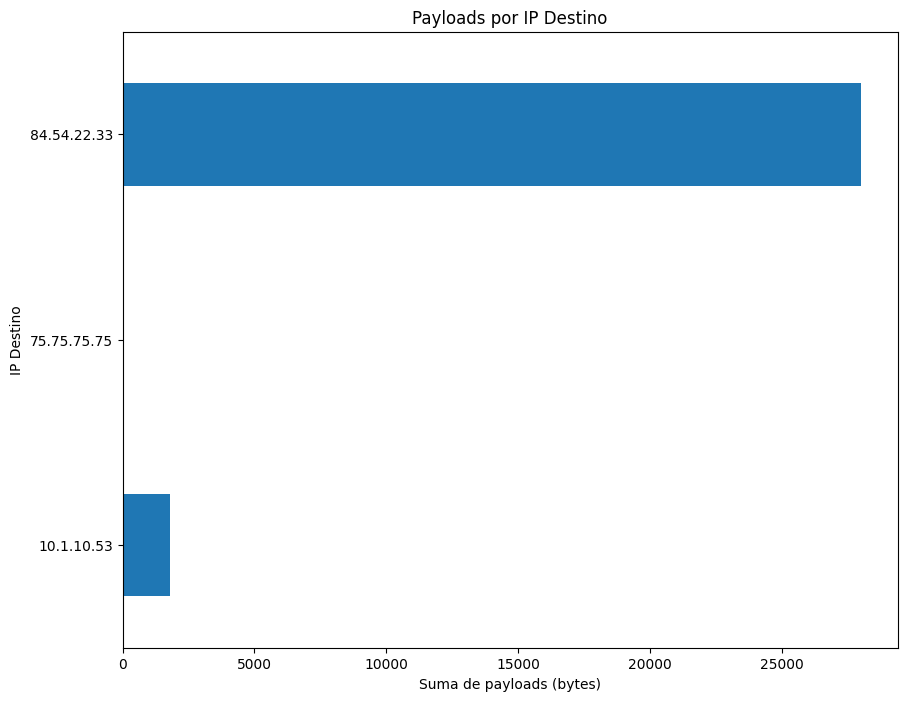

In [78]:
payloads_por_ip_destino = df.groupby('dst')['payload'].sum()

# Crear la graficas
plt.figure(figsize=(10, 8))
payloads_por_ip_destino.plot(kind='barh')
plt.title('Payloads por IP Destino')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('IP Destino')
plt.show()

c. Grafica suma de payloads por puertos origen

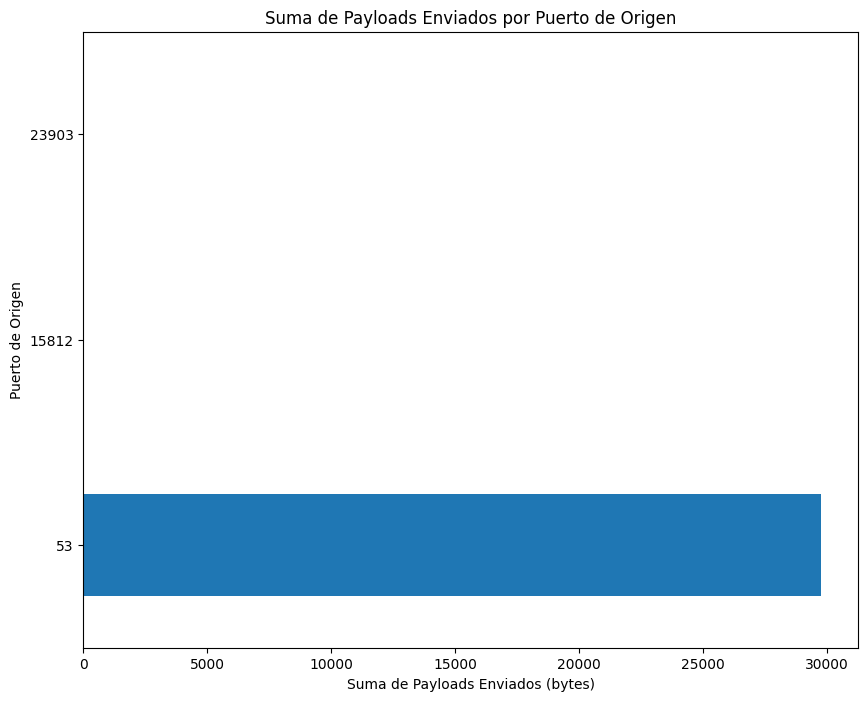

In [77]:
payloads_por_source_ports = df.groupby('sport')['payload'].sum()

# Crear la gráfica de barras horizontales
plt.figure(figsize=(10, 8))
payloads_por_source_ports.plot(kind='barh')
plt.title('Suma de Payloads Enviados por Puerto de Origen')
plt.xlabel('Suma de Payloads Enviados (bytes)')
plt.ylabel('Puerto de Origen')
plt.show()

d. Grafica suma de payloads por puerto destino

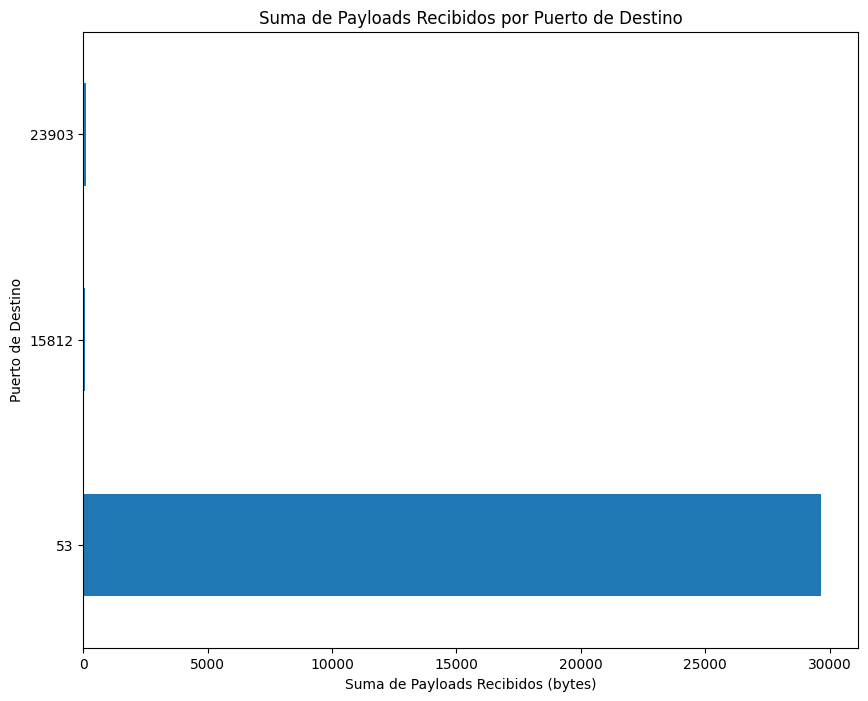

In [80]:
payloads_por_dest_ports = df.groupby('dport')['payload'].sum()

# Crear la gráfica de barras horizontales
plt.figure(figsize=(10, 8))
payloads_por_dest_ports.plot(kind='barh')
plt.title('Suma de Payloads Recibidos por Puerto de Destino')
plt.xlabel('Suma de Payloads Recibidos (bytes)')
plt.ylabel('Puerto de Destino')
plt.show()

e. Suma de Payloads por Tiempo para la IP de Origen más Frecuentema 

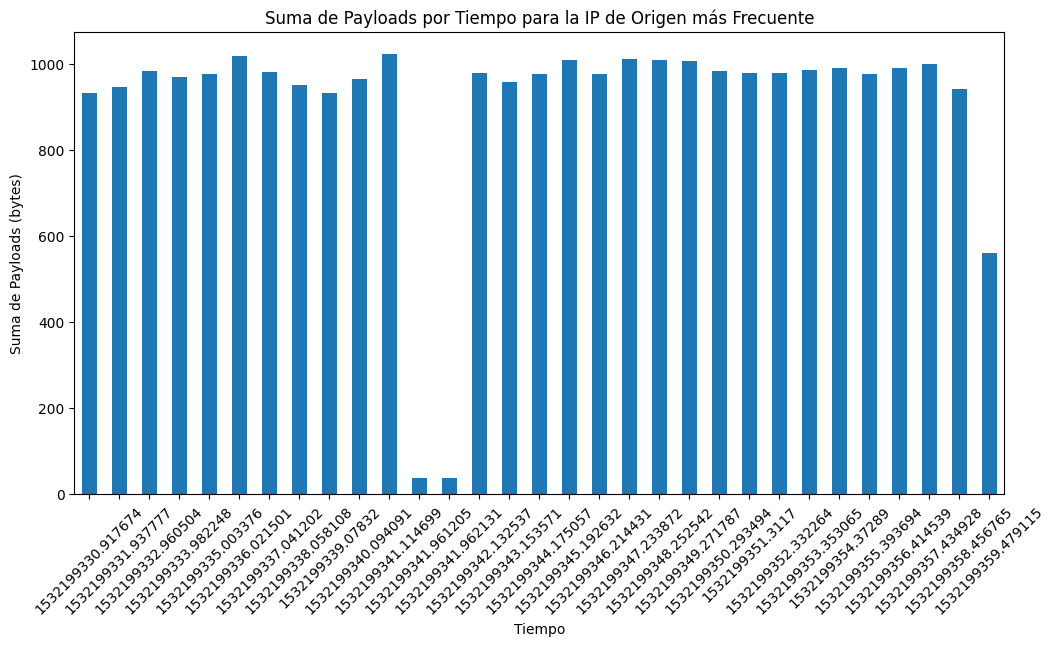

In [86]:
# Convertir el campo 'time' a tipo float
df['time'] = df['time'].astype(float)

# Filtrar los datos para quedarnos únicamente con los paquetes enviados desde la dirección IP de origen más frecuente
filtered_df = df[df['src'] == most_frequent_src_ip]

# Agrupar los datos por tiempo y sumar los payloads correspondientes
payloads_por_tiempo = filtered_df.groupby('time')['payload'].sum()

# Crear la gráfica de barras verticales
plt.figure(figsize=(12, 6))
payloads_por_tiempo.plot(kind='bar')
plt.ylabel('Suma de Payloads (bytes)')
plt.xlabel('Tiempo')
plt.title('Suma de Payloads por Tiempo para la IP de Origen más Frecuente')
plt.xticks(rotation=45)
plt.show()

f. Descripción de lo ocurrido

Basado en el hecho de que estoy en mi casa, el comportamiento de las gráficas parece ser mayormente normal y consistente con las actividades típicas en una red doméstica. La predominancia de ciertas direcciones IP y puertos, así como la distribución de payloads y tiempos, sugiere un patrón de tráfico coherente con el uso común de una red doméstica. Por ejemplo, la dirección IP de origen más frecuente, junto con los puertos 53 como origen y destino principales, refleja la actividad de resolución de nombres de dominio asociada con la navegación web habitual. Asimismo, la variación en la cantidad de payloads y tiempos puede estar relacionada con las múltiples actividades en línea, como navegación, streaming y descargas, que son comunes en un entorno doméstico.

**7. Investigacion del payload**

a. Crear DF que incluya unicamente las conexciones IP Origen mas frecuente

In [91]:
df_filtered = df[df['src'] == most_frequent_src_ip].copy()

df_filtered.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [92]:
df_filtered['src']

0     10.1.10.53
2     10.1.10.53
4     10.1.10.53
6     10.1.10.53
8     10.1.10.53
10    10.1.10.53
12    10.1.10.53
14    10.1.10.53
16    10.1.10.53
18    10.1.10.53
20    10.1.10.53
22    10.1.10.53
23    10.1.10.53
26    10.1.10.53
28    10.1.10.53
30    10.1.10.53
32    10.1.10.53
34    10.1.10.53
36    10.1.10.53
38    10.1.10.53
40    10.1.10.53
42    10.1.10.53
44    10.1.10.53
46    10.1.10.53
48    10.1.10.53
50    10.1.10.53
52    10.1.10.53
54    10.1.10.53
56    10.1.10.53
58    10.1.10.53
60    10.1.10.53
Name: src, dtype: object

b. Crear nuevo DF

In [93]:
# Agrupar el DataFrame anterior por 'dst' y sumar los payloads
df_grouped_by_dst = df_filtered.groupby('dst')['payload'].sum().reset_index()

# Verificar el nuevo DataFrame
print(df_grouped_by_dst.head())

           dst payload
0  75.75.75.75      74
1  84.54.22.33   27979


c. Obtener IP Destino que mas ha intercambiado bytes con IP frecuente

In [94]:
most_communicated_dst_ip = df_grouped_by_dst[df_grouped_by_dst['payload'] == df_grouped_by_dst['payload'].max()]['dst'].values[0]

print("La IP destino que más ha intercambiado bytes con la IP más frecuente es:", most_communicated_dst_ip)

La IP destino que más ha intercambiado bytes con la IP más frecuente es: 84.54.22.33


d. Crear nuevo DF con la conversacion entre IP mas frecuente e IP sospechosa

In [97]:
# Filtrar el DataFrame original para incluir solo las conversaciones entre la IP más frecuente y la IP sospechosa
df_conversation = df[(df['src'] == most_frequent_src_ip) & (df['dst'] == most_communicated_dst_ip)].copy()

# Verificar el nuevo DataFrame
df_conversation.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


e. Obtener payloads del DF anterior

In [145]:
payloads_array = df_conversation['payload'].tolist()
print("Payloads: ", payloads_array)

Payloads:  [933, 947, 984, 970, 975, 1017, 980, 951, 931, 964, 1023, 978, 958, 976, 1009, 976, 1011, 1009, 1007, 982, 978, 978, 985, 991, 977, 989, 999, 941, 560]


f. Mostrar array

In [146]:
# Convertir los payloads a formato hexadecimal y obtener los primeros bytes de cada uno
for i, payload in enumerate(payloads_array):
    payload_bytes = df_conversation.iloc[i]['payload_raw']
    hex_payload = binascii.hexlify(payload_bytes)[:16]
    print(f"Payload {i+1}: {payload}, hex: {hex_payload}")


Payload 1: 933, hex: b'000c010000010000'
Payload 2: 947, hex: b'000c010000010000'
Payload 3: 984, hex: b'000c010000010000'
Payload 4: 970, hex: b'000c010000010000'
Payload 5: 975, hex: b'000c010000010000'
Payload 6: 1017, hex: b'000c010000010000'
Payload 7: 980, hex: b'000c010000010000'
Payload 8: 951, hex: b'000c010000010000'
Payload 9: 931, hex: b'000c010000010000'
Payload 10: 964, hex: b'000c010000010000'
Payload 11: 1023, hex: b'000c010000010000'
Payload 12: 978, hex: b'000c010000010000'
Payload 13: 958, hex: b'000c010000010000'
Payload 14: 976, hex: b'000c010000010000'
Payload 15: 1009, hex: b'000c010000010000'
Payload 16: 976, hex: b'000c010000010000'
Payload 17: 1011, hex: b'000c010000010000'
Payload 18: 1009, hex: b'000c010000010000'
Payload 19: 1007, hex: b'000c010000010000'
Payload 20: 982, hex: b'000c010000010000'
Payload 21: 978, hex: b'000c010000010000'
Payload 22: 978, hex: b'000c010000010000'
Payload 23: 985, hex: b'000c010000010000'
Payload 24: 991, hex: b'000c010000010

g. Observar contenido y describir lo que se encontro


Observando los primeros bytes del contenido de los payloads proporcionados, noto que uno de los payloads tiene una longitud inusualmente corta en comparación con los demás. El payload tiene una longitud de 560 bytes, mientras que la mayoría de los otros payloads tienen longitudes más cercanas a los 1000 bytes.

Dado que el puerto destino en cuestión es el puerto 53, que normalmente se utiliza para la resolución de nombres de dominio (DNS), es poco común que un payload tan corto se envíe a este puerto. Los payloads típicos enviados a través del puerto 53 suelen contener consultas DNS o respuestas DNS, que pueden ser más largas debido a la información adicional incluida en las respuestas DNS, como registros de recursos y datos de configuración.

Por lo tanto, es posible que el payload con una longitud de 560 bytes sea inusual o no esté relacionado con las actividades típicas de un servicio DNS. 